**Import** all required libraries

In [2]:
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from glob import glob
from tensorflow.keras.layers.experimental.preprocessing import Rescaling
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization, Conv2D, MaxPooling2D
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import warnings
import PIL
from IPython.display import Image,display,HTML

In [3]:
# Check for GPU availability for image handling - specific to collab
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
# Ignore warning messages
warnings.filterwarnings('ignore')

**1. Data path definition and reading data**

In [72]:
# If you are using the data by mounting the google drive, use below approach:

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [6]:
# Defining the path for Train and Test images data set
## "/content/gdrive/MyDrive/Data_Melanoma/Images/Train"
traindata_path="/content/gdrive/MyDrive/Data_Melanoma/Images/Train"
testdata_path="/content/gdrive/MyDrive/Data_Melanoma/Images/Test"

data_directory_train = pathlib.Path(traindata_path)
data_directory_test = pathlib.Path(testdata_path)


In [7]:
print('Classes available for training')
print('+++++++++++++++++++++++++++++++')
os.listdir(data_directory_train)

Classes available for training
+++++++++++++++++++++++++++++++


['actinic keratosis',
 'squamous cell carcinoma',
 'nevus',
 'basal cell carcinoma',
 'dermatofibroma',
 'vascular lesion',
 'melanoma',
 'seborrheic keratosis',
 'pigmented benign keratosis']

In [8]:
# Check for count of images available in Train and Test
image_count_train = len(list(data_directory_train.glob('*/*.jpg')))
print(f'Total Images available for training: {image_count_train}')
image_count_test = len(list(data_directory_test.glob('*/*.jpg')))
print(f'Total Images available for testing: {image_count_test}')

Total Images available for training: 2239
Total Images available for testing: 118


 **2.Dataset Creation:**

In [9]:
batch_size = 32
img_height = 180
img_width = 180

Use 80% of the images for training, and 20% for validation.

 Train Data set creation:

In [10]:
# Generating Train dataset using tf.keras.preprocessing.image_dataset_from_directory.
# Set the seed parameter to 123. 
# Additionally,images are resized to the specified dimensions img_height by img_width , in this case 180 * 180.
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='training',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 1792 files for training.


Validation Data set creation:

In [11]:
# Generating Validation dataset using tf.keras.preprocessing.image_dataset_from_directory.
# Set the seed parameter to 123. 
# Additionally,images are resized to the specified dimensions img_height by img_width , in this case 180 * 180.
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_directory_train, labels='inferred', label_mode='categorical',
    class_names=None, color_mode='rgb', batch_size=32, image_size=(180,
    180), shuffle=True, seed=123, validation_split=0.2, subset='validation',
    interpolation='bilinear', follow_links=False, smart_resize=False
)

Found 2239 files belonging to 9 classes.
Using 447 files for validation.


In [12]:
# List out all the classes of skin cancer and store them in a list.
# You can find the class names in the class_names attribute on these datasets.
# These correspond to the directory names in alphabetical order.
class_names = train_ds.class_names
display(class_names)

['actinic keratosis',
 'basal cell carcinoma',
 'dermatofibroma',
 'melanoma',
 'nevus',
 'pigmented benign keratosis',
 'seborrheic keratosis',
 'squamous cell carcinoma',
 'vascular lesion']

**3. Dataset Visualisation:**

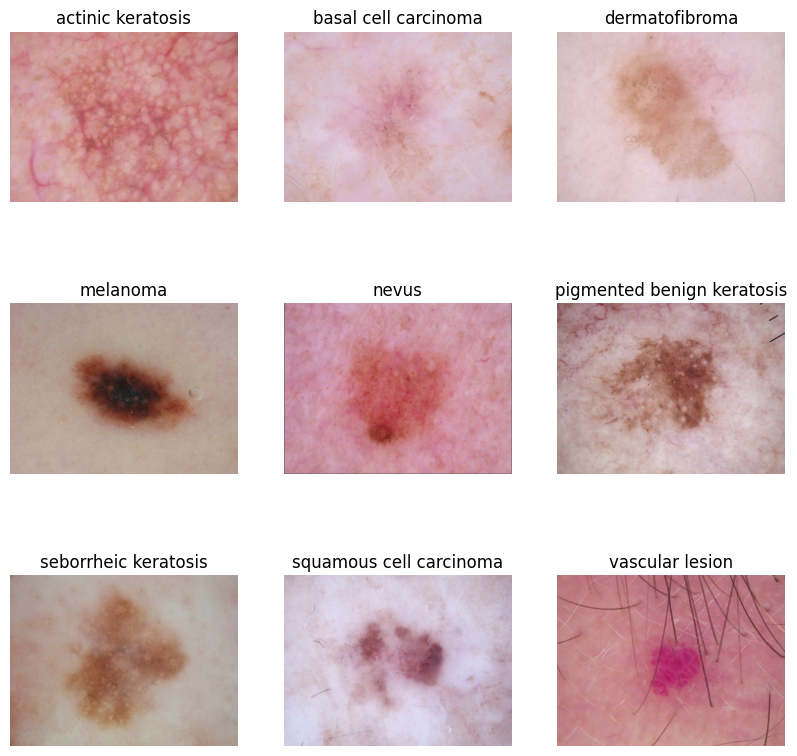

In [13]:
# Visualize one instance of all the nine classes present in the dataset

plt.figure(figsize=(10,10))
for i in range(9):
  plt.subplot(3,3,i+1)
  image = plt.imread(
      str(list(data_directory_train.glob(f'{class_names[i]}/*.jpg'))[1]))
  plt.title(class_names[i])
  plt.imshow(image)
  plt.axis('off')

The set of images, known as the image_batch, is organized as a grid with dimensions (32, 180, 180, 3). This means we have 32 images, each with a size of 180 by 180 pixels and three color channels (representing RGB colors). The labels corresponding to these images, named label_batch, form a one-dimensional tensor with a shape of (32,).

Dataset.cache(): After the images are initially loaded from the storage (like a disk) during the first round of training (or epoch), they are kept in the computer's memory. This is a handy way to speed up access to the images, as the computer doesn't need to fetch them from storage each time; it can use the faster-to-access memory.

Dataset.prefetch(): Technique that helps with efficiency during training. It means that while the model is in the middle of learning from the current batch of images, in the background, the system is already starting to prepare the next set of images. This overlap ensures that the model doesn't have to wait for data to be ready, and the training process can continue smoothly.

In [14]:
# Use AUTOTUNE for dynamic adjustment of the number of parallel calls during data loading.
# Cache the training dataset for improved performance by storing it in memory after the first epoch.
# Shuffle the training dataset with a buffer size of 1000 for better randomness.
# Prefetch the training dataset to overlap data preprocessing and model training for better performance.

AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [15]:
# image count in each classes
class_diff=pd.DataFrame()
for i in range(len(class_names)):
  name= class_names[i]
  number = len(list(data_directory_train.glob(f'{class_names[i]}/*.jpg')))
  class_diff=class_diff.append({'Class':name,'No. of Images':number},ignore_index=True)

class_diff

,Class,No. of Images
0,actinic keratosis,114
1,basal cell carcinoma,376
2,dermatofibroma,95
3,melanoma,438
4,nevus,357
5,pigmented benign keratosis,462
6,seborrheic keratosis,77
7,squamous cell carcinoma,181
8,vascular lesion,139


In [16]:
# Images in each classes in terms of percentage
for image_class in class_names:
    n_images_per_class = len(list(data_directory_train.joinpath(image_class).glob('*.jpg')))
    print(f'No. of images for the class {image_class} is {n_images_per_class} ( {(n_images_per_class/image_count_train)*100} )')

No. of images for the class actinic keratosis is 114 ( 5.091558731576597 )
No. of images for the class basal cell carcinoma is 376 ( 16.793211255024566 )
No. of images for the class dermatofibroma is 95 ( 4.242965609647164 )
No. of images for the class melanoma is 438 ( 19.56230460026798 )
No. of images for the class nevus is 357 ( 15.944618133095132 )
No. of images for the class pigmented benign keratosis is 462 ( 20.634211701652525 )
No. of images for the class seborrheic keratosis is 77 ( 3.439035283608754 )
No. of images for the class squamous cell carcinoma is 181 ( 8.083966056275123 )
No. of images for the class vascular lesion is 139 ( 6.208128628852166 )


<Axes: xlabel='No. of Images', ylabel='Class'>

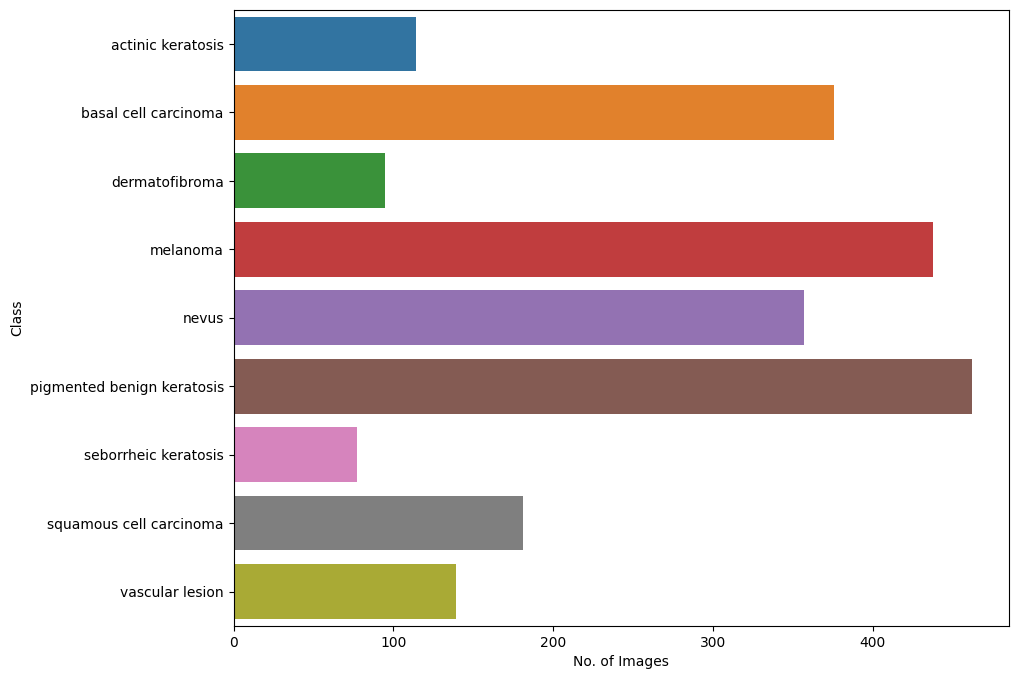

In [17]:
# Visualize the Number of image in each class.
import seaborn as sns
plt.figure(figsize=(10, 8))
sns.barplot(x="No. of Images", y="Class", data=class_diff,
            label="Class")

**4. Model 1: Minimal Dropout strategy** 



**Model creation** :
Create a CNN model that can correctly find 9 different things in a set of pictures. To make the model work better, use a process called Rescaling to change the colors in the pictures so the computer can understand them better. The colors in the pictures right now are in a range that's not great for the computer, so it's better to make them fit in a range between 0 and 1.

In [18]:
# Define the number of classes based on the length of the class names.
num_classes = len(class_names)

# Create a sequential model using the Keras Sequential API.
# Rescale pixel values to the range [0, 1].
# First convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and same padding.
# Max pooling layer with a 2x2 pool size.
# Second convolutional layer with 64 filters, a 3x3 kernel, ReLU activation, and same padding.
# Dropout layer with a dropout rate of 0.1 for regularization.
# Flatten the output to be fed into the dense layers.
# Dropout layer with a dropout rate of 0.25 for regularization.
# Output layer with 'num_classes' neurons and softmax activation for classification.

model=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(num_classes, activation='softmax')
])

**Compiling the Model**

In [19]:
# Selecting an appropriate optimiser and loss function
# Compile the model with specified configurations for training.
# Use the Adam optimizer for efficient gradient-based optimization.
# Specify categorical crossentropy as the loss function for multi-class classification.
# Track accuracy as a metric to monitor model performance during training.

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

**Training the Model**

In [20]:
# Set the number of training epochs to 20.
# Train the model using the fit method on the training dataset.
# Use the validation dataset for monitoring model performance during training.
# The training history is stored in the 'history' variable.

epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 375s 1s/step - loss: 3.5102 - accuracy: 0.1914 - val_loss: 2.0208 - val_accuracy: 0.3266
Epoch 2/20
56/56 [==============================] - 3s 56ms/step - loss: 1.8471 - accuracy: 0.3203 - val_loss: 1.8928 - val_accuracy: 0.3490
Epoch 3/20
56/56 [==============================] - 3s 61ms/step - loss: 1.7535 - accuracy: 0.3767 - val_loss: 1.6700 - val_accuracy: 0.4497
Epoch 4/20
56/56 [==============================] - 3s 59ms/step - loss: 1.5876 - accuracy: 0.4425 - val_loss: 1.6252 - val_accuracy: 0.4586
Epoch 5/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4878 - accuracy: 0.4771 - val_loss: 1.6265 - val_accuracy: 0.4765
Epoch 6/20
56/56 [==============================] - 3s 56ms/step - loss: 1.4158 - accuracy: 0.5240 - val_loss: 1.4423 - val_accuracy: 0.5302
Epoch 7/20
56/56 [==============================] - 3s 57ms/step - loss: 1.3536 - accuracy: 0.5167 - val_loss: 1.4796 - val_accuracy: 0.5101
Epoch 8/20
56

In [21]:
# Display a summary of all layers in the model, including information on the number of parameters.
# The model summary provides an overview of the architecture and parameter counts.
display(
    model.summary(),
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 180, 180, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 180, 180, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 90, 90, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 90, 90, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 90, 90, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 45, 45, 64)        0         
 g2D)                                                   

None

**Visualizing training results**

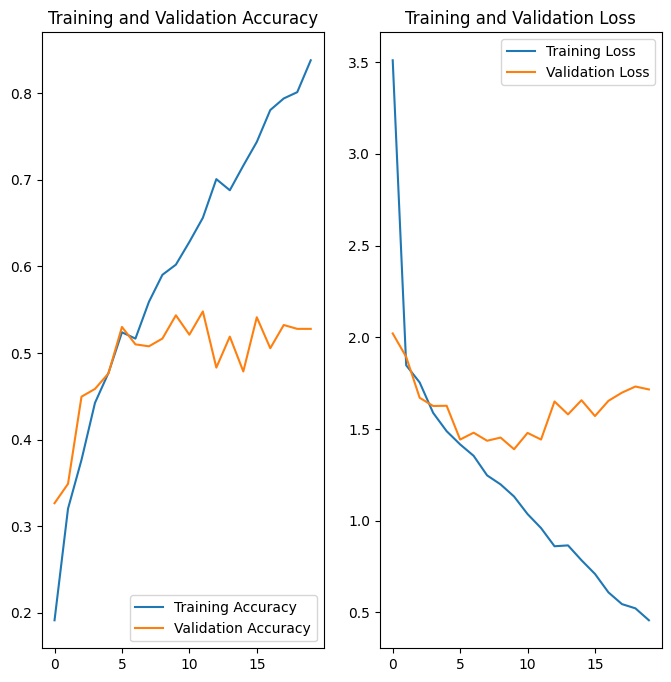

None

In [22]:
# Extracting accuracy, loss, validation accuracy, and validation loss from the training history.
# Create a 2x1 subplot for displaying training and validation metrics.
# Plotting Training and Validation Accuracy in the first subplot.
# Plotting Training and Validation Loss in the second subplot.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
display(plt.show())

**Observation(s):**
* The model is performing well on the training dataset, achieving an accuracy of **~80%**. However, there's a noticeable discrepancy when it comes to the validation dataset, where the accuracy is significantly lower at **~ 55**%. This discrepancy, coupled with a high validation loss, suggests a potential **overfitting** issue in the model.

* To address this, a strategy is proposed. One approach is to introduce some more Dropout layers while removing BatchNormalization layers. Dropout helps prevent overfitting by randomly deactivating some neurons during training. Additionally, the suggestion involves expanding the model with a few more layers to enhance its capability to extract diverse features. By implementing these changes, the aim is to bring the training and validation accuracies closer and improve overall model performance.

**5. Model 2:** Creating Model by adding some more dropouts.

In [23]:
# Create a sequential model using the Keras Sequential API.
# Rescale pixel values to the range [0, 1].
# First convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and same padding.
# Max pooling layer with a 2x2 pool size.
# Second convolutional layer with 64 filters, a 3x3 kernel, ReLU activation, and same padding.
# Dropout layer with a dropout rate of 0.7 for regularization.
# Flatten the output to be fed into the dense layers.
# Dropout layer with a dropout rate of 0.25 for regularization.
# Output layer with 'num_classes' (in this case 9 classes) neurons and softmax activation for classification.

model_update=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

**Compile Model:**

In [24]:
# Selecting an appropriate optimiser and loss function
# Compile the model with specified configurations for training.
# Use the Adam optimizer for efficient gradient-based optimization.
# Specify categorical crossentropy as the loss function for multi-class classification.
# Track accuracy as a metric to monitor model performance during training.

model_update.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

**Training Model:**

In [25]:
# Set the number of training epochs to 20.
# Train the model using the fit method on the training dataset.
# Use the validation dataset for monitoring model performance during training.
# The training history is stored in the 'history' variable.

epochs = 20
history = model_update.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 11s 123ms/step - loss: 2.1585 - accuracy: 0.1802 - val_loss: 2.0771 - val_accuracy: 0.1924
Epoch 2/20
56/56 [==============================] - 6s 107ms/step - loss: 2.0368 - accuracy: 0.1964 - val_loss: 2.0230 - val_accuracy: 0.1924
Epoch 3/20
56/56 [==============================] - 6s 109ms/step - loss: 1.9676 - accuracy: 0.2182 - val_loss: 1.9038 - val_accuracy: 0.3714
Epoch 4/20
56/56 [==============================] - 6s 108ms/step - loss: 1.8804 - accuracy: 0.2907 - val_loss: 1.7715 - val_accuracy: 0.3669
Epoch 5/20
56/56 [==============================] - 6s 107ms/step - loss: 1.7686 - accuracy: 0.3717 - val_loss: 1.7126 - val_accuracy: 0.3624
Epoch 6/20
56/56 [==============================] - 6s 108ms/step - loss: 1.6872 - accuracy: 0.3845 - val_loss: 1.6915 - val_accuracy: 0.4027
Epoch 7/20
56/56 [==============================] - 6s 107ms/step - loss: 1.6424 - accuracy: 0.3968 - val_loss: 1.6512 - val_accuracy: 0.3848
Epoch

**Visualizing results after adding some more dropouts to model.**

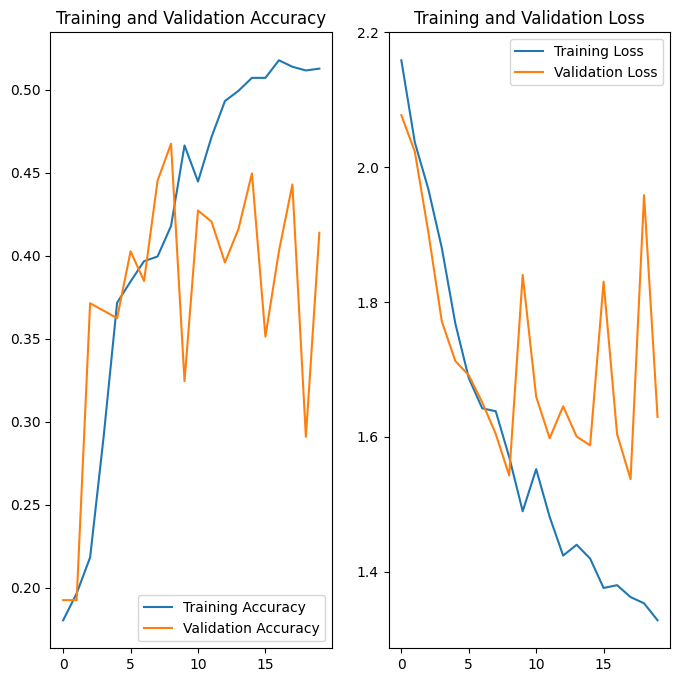

None

In [26]:
# Extracting accuracy, loss, validation accuracy, and validation loss from the training history.
# Create a 2x1 subplot for displaying training and validation metrics.
# Plotting Training and Validation Accuracy in the first subplot.
# Plotting Training and Validation Loss in the second subplot.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
display(plt.show())

**Observation(s):**

* Training data set accuracy: Nearly 45%
* Validation set accuracy: 40%
* The close similarity between training accuracy and validation accuracy, both at a low level, suggests that the model is experiencing **underfitting**. While the training loss is minimal, the validation loss exhibits fluctuations, indicating potential challenges in generalizing to new data.
* In scenarios with a limited number of training examples, the model may inadvertently pick up on irrelevant details or noise from the training data. This can have a detrimental effect on the model's performance when applied to new examples which can be resolved using **"Data Augmentation"** approach.

**6. Data Augmentation:** Technique used in Convolutional Neural Networks (CNNs) to artificially increase the size of the training dataset by applying various transformations to the existing images by helping to increase the diversity of training data and improve the robustness of model(s).

In [27]:
# Define a data augmentation pipeline using the Keras Sequential API.
# This pipeline includes two data augmentation layers: RandomFlip and RandomRotation.
# RandomFlip layer flips input images horizontally and vertically for increased variability.
# It helps the model generalize better by presenting diverse perspectives of the same object.
# "horizontal_and_vertical" specifies flipping along both horizontal and vertical axes.

# RandomRotation layer randomly rotates input images by a specified fraction (0.2 in this case).
# It introduces variability in the orientation of objects, promoting robustness in training.

data_augmentation=tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2)
])


**Visualizing Augmented Data**

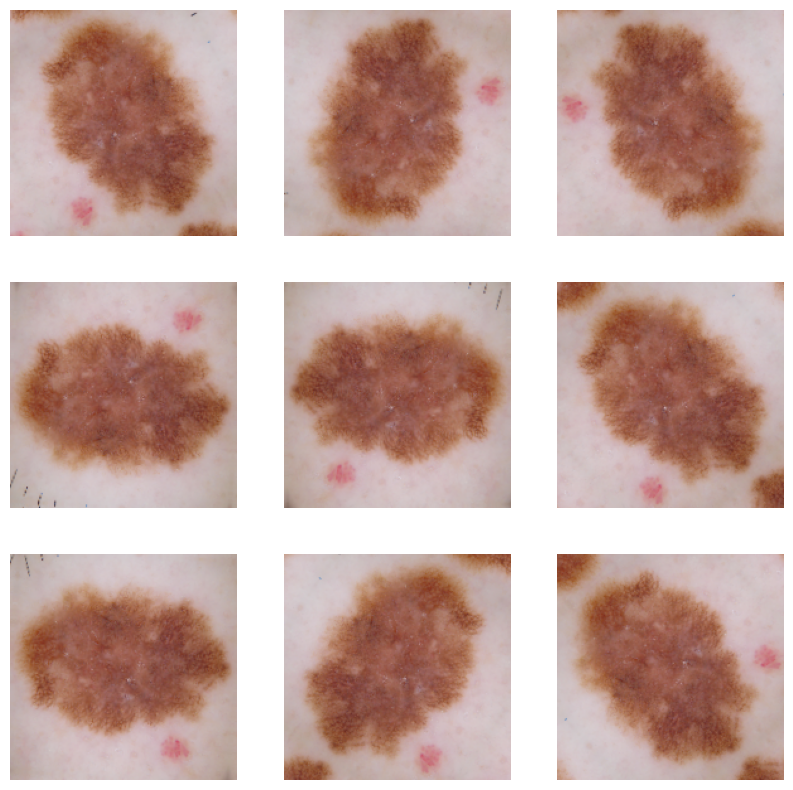

In [28]:
# Retrieve a batch of images and labels from the training dataset using an iterator.
# Create a figure with a size of 10x10 for displaying augmented images.
# Iterate over 9 samples to visualize the original and augmented images.
# Apply data augmentation to the original image.
# Convert the augmented image array to int32 for visualization purposes. 
# Create subplots in a 3x3 grid for displaying original and augmented images.

image, label = next(iter(train_ds))
image=np.array(image,np.int32)
plt.figure(figsize=(10, 10))
for i in range(9):
  augmented_image = data_augmentation(image)
  ax = plt.subplot(3, 3, i + 1)
  augmented_image1=np.array(augmented_image[0],np.int32)
  plt.imshow((augmented_image1))
  plt.axis("off")

**Model 3: Using Data Augmentaion**

In [29]:
# Create a new sequential model with data augmentation for training.
# Rescale pixel values to the range [0, 1].
# Apply the previously defined data augmentation pipeline.
# First convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and same padding.
# Second convolutional layer with 64 filters, a 3x3 kernel, ReLU activation, and same padding.
# Additional convolutional layer with 64 filters and a 3x3 kernel, followed by ReLU activation.
# Max pooling layer with a 2x2 pool size.
# Dropout layer with a dropout rate of 0.7 for regularization.
# Third convolutional layer with 128 filters, a 3x3 kernel, ReLU activation, and same padding.
# Flatten the output to be fed into the dense layers.
# Fully connected dense layer with 128 neurons and ReLU activation.
# Dropout layer with a dropout rate of 0.25 for regularization.
# Output layer with 9 neurons (in this case) and softmax activation for classification.

model_augmented=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    data_augmentation,

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    Conv2D(32,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    Conv2D(64,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Conv2D(128,(3,3),activation='relu',padding='same'),
    Conv2D(128,(3,3),activation='relu'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.7),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

**Compiling the Model**

In [30]:
# Selecting an appropriate optimiser and loss function
# Compile the model with specified configurations for training.
# Use the Adam optimizer for efficient gradient-based optimization.
# Specify categorical crossentropy as the loss function for multi-class classification.
# Track accuracy as a metric to monitor model performance during training.

model_augmented.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

**Training the Model**

In [31]:
# Set the number of training epochs to 20.
# Train the model using the fit method on the training dataset.
# Use the validation dataset for monitoring model performance during training.
# The training history is stored in the 'history' variable.

epochs = 20
history = model_augmented.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20
56/56 [==============================] - 9s 117ms/step - loss: 2.1615 - accuracy: 0.1875 - val_loss: 2.0579 - val_accuracy: 0.2058
Epoch 2/20
56/56 [==============================] - 6s 111ms/step - loss: 2.0485 - accuracy: 0.1836 - val_loss: 2.0403 - val_accuracy: 0.2058
Epoch 3/20
56/56 [==============================] - 6s 113ms/step - loss: 2.0349 - accuracy: 0.1842 - val_loss: 2.0407 - val_accuracy: 0.2058
Epoch 4/20
56/56 [==============================] - 6s 112ms/step - loss: 2.0314 - accuracy: 0.1953 - val_loss: 2.0382 - val_accuracy: 0.1924
Epoch 5/20
56/56 [==============================] - 6s 111ms/step - loss: 2.0162 - accuracy: 0.2003 - val_loss: 2.0165 - val_accuracy: 0.1924
Epoch 6/20
56/56 [==============================] - 6s 113ms/step - loss: 2.0044 - accuracy: 0.2260 - val_loss: 2.0392 - val_accuracy: 0.2058
Epoch 7/20
56/56 [==============================] - 6s 111ms/step - loss: 1.9606 - accuracy: 0.2606 - val_loss: 1.9066 - val_accuracy: 0.3110
Epoch 

**Visualizing results with Data Augmentation**

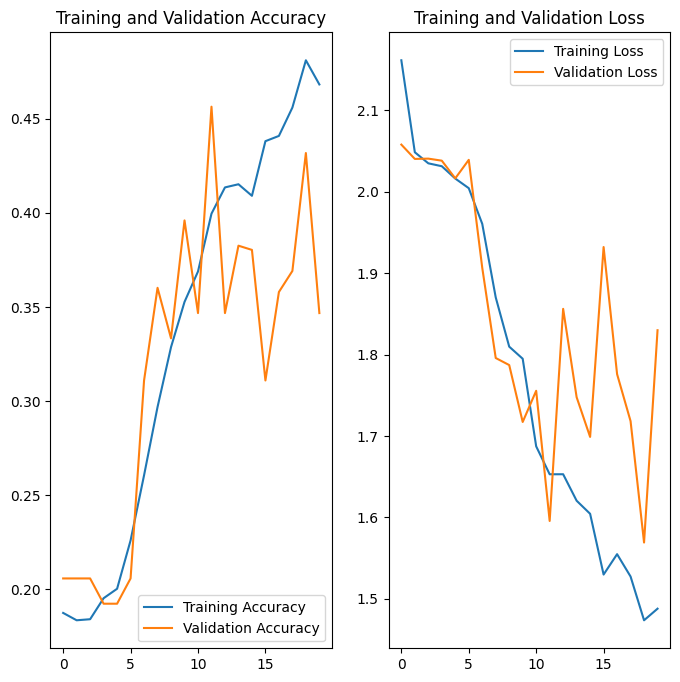

None

In [32]:
# Extracting accuracy, loss, validation accuracy, and validation loss from the training history.
# Create a 2x1 subplot for displaying training and validation metrics.
# Plotting Training and Validation Accuracy in the first subplot.
# Plotting Training and Validation Loss in the second subplot.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
display(plt.show())

 **Observation(s):**
* Training Data Set Accuracy: Increased to nearly 48%
* Validation Set Accuracy: Also at 48%
* Model Comparison: Improved compared to the previous two models
* Overfitting Observation: **No overfitting** apparent, with both training and validation accuracies at 48%
* Impact of Data Augmentation: Model performance enhanced through the use of Data Augmentation.
* The convergence of training accuracy and validation accuracy suggests a good fit, yet the overall accuracy remains relatively low. To address this issue, additional epochs are needed, taking into account the handling of class imbalances in the training data.

**7. Check for Class Imbalance:**

Frequently, real-world datasets exhibit class imbalance, where one class has a significantly higher number of samples compared to others. This imbalance can adversely impact the ultimate quality of the model. Therefore, it is crucial to perform a sanity check by examining the distribution of classes in the data.

In [33]:
# Iterate over each class name in the 'class_names' list.
# Construct the path to the directory containing images for the current class.
# Create a Path object for the class directory.
# Count the number of files with the '*.jpg' extension in the class directory.
# Display the class name along with the number of samples(yet to add samples - cross check values are 0) in the class.

for i in class_names:
    directory =traindata_path+i+'/'
    class_directory = pathlib.Path(directory)
    length=len(list(class_directory.glob('*.jpg')))
    display(f'{i} has {length} samples.')

'actinic keratosis has 0 samples.'

'basal cell carcinoma has 0 samples.'

'dermatofibroma has 0 samples.'

'melanoma has 0 samples.'

'nevus has 0 samples.'

'pigmented benign keratosis has 0 samples.'

'seborrheic keratosis has 0 samples.'

'squamous cell carcinoma has 0 samples.'

'vascular lesion has 0 samples.'

In [34]:
# Images in each classes in terms of percentage
for image_class in class_names:
    n_images_per_class = len(list(data_directory_train.joinpath(image_class).glob('*.jpg')))
    print(f'No. of images for the class {image_class} is {n_images_per_class} ( {(n_images_per_class/image_count_train)*100} )')

No. of images for the class actinic keratosis is 114 ( 5.091558731576597 )
No. of images for the class basal cell carcinoma is 376 ( 16.793211255024566 )
No. of images for the class dermatofibroma is 95 ( 4.242965609647164 )
No. of images for the class melanoma is 438 ( 19.56230460026798 )
No. of images for the class nevus is 357 ( 15.944618133095132 )
No. of images for the class pigmented benign keratosis is 462 ( 20.634211701652525 )
No. of images for the class seborrheic keratosis is 77 ( 3.439035283608754 )
No. of images for the class squamous cell carcinoma is 181 ( 8.083966056275123 )
No. of images for the class vascular lesion is 139 ( 6.208128628852166 )


**Observation(s):**
* The dataset exhibits noticeable class imbalance, with unequal proportions of samples across various classes.
* **Seborrheic Keratosi**s has the fewest samples, totaling 77.
* **Pigmented Benign Keratosis** and **Melanoma** overwhelmingly dominates the dataset with a substantial sample size of 462 and 438 respectively.
* Need to resolve Class imabalance.

**Augmentor:**

Powerful Python library for image augmentation, which can be used to address class imbalance in a dataset.

Step-by-step procedure on using Augmentor for class imbalance treatment:

* Create a Pipeline object, specifying the directory containing the initial image data set.
* Specify a set of operations to be applied to the data set using the created Pipeline object.
* Perform the defined operations by invoking the sample() method of the Pipeline.

In [35]:
#Installing Augmentor

!pip install Augmentor

In [36]:
# Using Augmentor :
# Define the path to the training dataset.
# Import the Augmentor library.
# Iterate over each class name in the 'class_names' list.
# Create an Augmentor Pipeline for the current class directory.
# Apply rotation augmentation with a probability of 0.7, maximum left rotation of 10 degrees and maximum right rotation of 10 degrees.
# Generate and save 500 augmented samples for the current class.

path_to_training_dataset = os.path.join('/content/gdrive/MyDrive/Data_Melanoma/Images','/content/gdrive/MyDrive/Data_Melanoma/Images/Train')
print(path_to_training_dataset)
import Augmentor
for i in class_names:
    p = Augmentor.Pipeline(path_to_training_dataset + os.path.sep + i)
    p.rotate(probability=0.7, max_left_rotation=10, max_right_rotation=10)
    p.sample(500) ## We are adding 500 samples per class to make sure that none of the classes are sparse.

/content/gdrive/MyDrive/Data_Melanoma/Images/Train
Initialised with 114 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_Melanoma/Images/Train/actinic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78902DB43FD0>: 100%|██████████| 500/500 [00:21<00:00, 23.22 Samples/s]


Initialised with 376 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_Melanoma/Images/Train/basal cell carcinoma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x7890CDB59510>: 100%|██████████| 500/500 [00:24<00:00, 20.20 Samples/s]


Initialised with 95 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_Melanoma/Images/Train/dermatofibroma/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78902D9E3C10>: 100%|██████████| 500/500 [00:23<00:00, 21.17 Samples/s]


Initialised with 438 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_Melanoma/Images/Train/melanoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=919x802 at 0x7890CDB5BC70>: 100%|██████████| 500/500 [01:26<00:00,  5.78 Samples/s]


Initialised with 357 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_Melanoma/Images/Train/nevus/output.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x78902C11F760>: 100%|██████████| 500/500 [01:18<00:00,  6.34 Samples/s]


Initialised with 462 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_Melanoma/Images/Train/pigmented benign keratosis/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78902DA4B9A0>: 100%|██████████| 500/500 [00:17<00:00, 27.84 Samples/s]


Initialised with 77 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_Melanoma/Images/Train/seborrheic keratosis/output.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x78902C11F730>: 100%|██████████| 500/500 [00:39<00:00, 12.57 Samples/s]


Initialised with 181 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_Melanoma/Images/Train/squamous cell carcinoma/output.

Processing <PIL.JpegImagePlugin.JpegImageFile image mode=RGB size=600x450 at 0x78902DA0F8E0>: 100%|██████████| 500/500 [00:18<00:00, 27.10 Samples/s]


Initialised with 139 image(s) found.
Output directory set to /content/gdrive/MyDrive/Data_Melanoma/Images/Train/vascular lesion/output.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x78902DA498D0>: 100%|██████████| 500/500 [00:18<00:00, 27.46 Samples/s]


The augmented images generated by Augmentor are located within the "output" sub-directory of each individual sub-directory corresponding to different types of skin cancer. Let's examine the overall count of augmented images across all categories.

In [37]:
# Count the number of images in the training dataset by listing all '*.jpg' files in the 'output' subdirectory of each class directory.
# Create a Path object for the training dataset directory.
# Use the 'glob' method to find all '*.jpg' files in the 'output' subdirectory of each class.
# Display the total number of images in the training dataset.

image_count_train = len(list(data_directory_train.glob('*/output/*.jpg')))
display(image_count_train)


4500

In [38]:
# Use the 'glob' function from the 'glob' module to create lists of file paths.
# Create a list of file paths for all '*.jpg' files in the 'output' subdirectory of each class.
# Create a list of file paths for all '*.jpg' files in the root of each class directory.

from glob import glob
path_list = [x for x in glob(os.path.join(data_directory_train, '*','output', '*.jpg'))]
path_list_original = [x for x in glob(os.path.join(data_directory_train, '*', '*.jpg'))]

In [39]:
# Extract lesion class names from the file paths using list comprehensions.
# Create a list of lesion class names for all '*.jpg' files in the 'output' subdirectory of each class.
# Create a list of lesion class names for all '*.jpg' files in the root of each class directory.

lesion_list_new = [os.path.basename(os.path.dirname(os.path.dirname(y))) for y in glob(os.path.join(data_directory_train, '*','output', '*.jpg'))]
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_directory_train, '*', '*.jpg'))]

In [40]:
# Create dictionaries mapping file paths to lesion class names using the 'zip' function.
# Create a dictionary mapping '*.jpg' file paths in the 'output' subdirectory to lesion class names.
# Create a dictionary mapping '*.jpg' file paths in the root of each class directory to lesion class names.
# Create a Pandas DataFrame using the items of the dictionary, with columns 'Path' and 'Label'.

dataframe_dict_new = dict(zip(path_list, lesion_list_new))
dataframe_dict_original = dict(zip(path_list_original, lesion_list_original))
original_df = pd.DataFrame(list(dataframe_dict_original.items()),columns = ['Path','Label'])


In [41]:
# Creating Data frame to check count of samples after class imbalance

df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
new_df = original_df.append(df2)

In [42]:
# Check count of available samples after class imbalance is resolved.

new_df['Label'].value_counts()

pigmented benign keratosis    962
melanoma                      938
basal cell carcinoma          876
nevus                         857
squamous cell carcinoma       681
vascular lesion               639
actinic keratosis             614
dermatofibroma                595
seborrheic keratosis          577
Name: Label, dtype: int64

In [43]:
# Check count of available samples after class imbalance is resolved.

for i in class_names:
    directory ='/content/gdrive/MyDrive/Data_Melanoma/Images/Train'
    directory_out ='/content/gdrive/MyDrive/Data_Melanoma/Images/Train'+'/'+i+'/output/'
    class_directory = pathlib.Path(directory)
    class_directory_out = pathlib.Path(directory_out)
    length=len(list(class_directory.glob(i+'/*.jpg')))
    length_out=len(list(class_directory_out.glob('*.jpg')))
    length_tot=length+length_out
    print(f'{i} has {length_tot} samples.')

actinic keratosis has 614 samples.
basal cell carcinoma has 876 samples.
dermatofibroma has 595 samples.
melanoma has 938 samples.
nevus has 857 samples.
pigmented benign keratosis has 962 samples.
seborrheic keratosis has 577 samples.
squamous cell carcinoma has 681 samples.
vascular lesion has 639 samples.


**Observation(s):**

* Augmentor has successfully addressed the imbalance in class images.
* The effectiveness of this balancing can be observed from the aforementioned information.
* A total of 500 images have been added to each class to achieve a more balanced representation.
* Further additions of images are possible to enhance the training process as needed.


**8. Model 4: Modelling Augmented Data (after class imbalance)**

In [44]:
batch_size = 32
img_height = 180
img_width = 180

**Train Dataset Creation:**

In [45]:
# After class imbalance resolve:
# Generating Train dataset using tf.keras.preprocessing.image_dataset_from_directory.
# Set the seed parameter to 123. 
# Additionally,images are resized to the specified dimensions img_height by img_width , in this case 180 * 180.

data_directory_train=data_directory_train
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'training',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 5392 files for training.


**Validation Dataset Creation:**

In [46]:
# After class imbalance resolve:
# Generating Validation dataset using tf.keras.preprocessing.image_dataset_from_directory.
# Set the seed parameter to 123. 
# Additionally,images are resized to the specified dimensions img_height by img_width , in this case 180 * 180.

val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  data_directory_train,
  seed=123, label_mode='categorical',
  validation_split = 0.2,
  subset = 'validation',
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 6739 files belonging to 9 classes.
Using 1347 files for validation.


**Model Creation:**

In [47]:
# Create a final sequential model for classification.

# Rescale pixel values to the range [0, 1].
# First convolutional layer with 32 filters, a 3x3 kernel, ReLU activation, and same padding.
# Max pooling layer with a 2x2 pool size.
# Dropout layer with a dropout rate of 0.1 for regularization.
# Second convolutional layer with 64 filters, a 3x3 kernel, ReLU activation, and same padding.
# Dropout layer with a dropout rate of 0.1 for regularization.
# Flatten the output to be fed into the dense layers.
# Fully connected dense layer with 128 neurons and ReLU activation.
# Dropout layer with a dropout rate of 0.25 for regularization.
# Output layer with 9 neurons (assuming 9 classes) and softmax activation for classification.

model_final=Sequential([
    tf.keras.layers.experimental.preprocessing.Rescaling(scale=1./255., offset=0.0,),

    Conv2D(32,(3,3),input_shape=(img_height,img_width,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Conv2D(64,(3,3),activation='relu',padding='same'),
    MaxPooling2D(pool_size=(2,2)),
    Dropout(0.1),

    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.25),
    Dense(9, activation='softmax')
])

**Compiling the Model:**


In [48]:
# Selecting an appropriate optimiser and loss function
# Compile the model with specified configurations for training.
# Use the Adam optimizer for efficient gradient-based optimization.
# Specify categorical crossentropy as the loss function for multi-class classification.
# Track accuracy as a metric to monitor model performance during training.

model_final.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics='accuracy')

**Training the Model:**

In [49]:
# Set the number of training epochs to 30 (Additional epochs to attain better accuracy).
# Train the model using the fit method on the training dataset.
# Use the validation dataset for monitoring model performance during training.
# The training history is stored in the 'history' variable.

epochs = 30

history = model_final.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/30
169/169 [==============================] - 38s 210ms/step - loss: 2.5848 - accuracy: 0.2066 - val_loss: 1.7841 - val_accuracy: 0.3957
Epoch 2/30
169/169 [==============================] - 37s 211ms/step - loss: 1.6530 - accuracy: 0.3704 - val_loss: 1.4997 - val_accuracy: 0.4566
Epoch 3/30
169/169 [==============================] - 36s 209ms/step - loss: 1.4324 - accuracy: 0.4618 - val_loss: 1.3559 - val_accuracy: 0.4848
Epoch 4/30
169/169 [==============================] - 35s 205ms/step - loss: 1.3318 - accuracy: 0.5026 - val_loss: 1.2376 - val_accuracy: 0.5427
Epoch 5/30
169/169 [==============================] - 41s 238ms/step - loss: 1.2022 - accuracy: 0.5538 - val_loss: 1.1172 - val_accuracy: 0.5783
Epoch 6/30
169/169 [==============================] - 36s 205ms/step - loss: 1.0801 - accuracy: 0.5983 - val_loss: 1.0532 - val_accuracy: 0.6028
Epoch 7/30
169/169 [==============================] - 35s 203ms/step - loss: 0.9432 - accuracy: 0.6502 - val_loss: 0.9371 - val_ac

**Visualizing results (after class imbalance)**

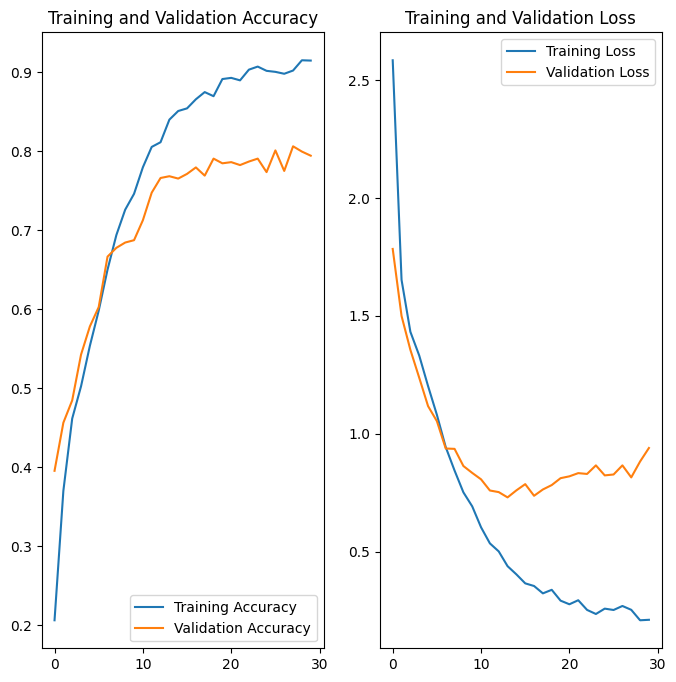

None

In [50]:
# Extracting accuracy, loss, validation accuracy, and validation loss from the training history.
# Create a 2x1 subplot for displaying training and validation metrics.
# Plotting Training and Validation Accuracy in the first subplot.
# Plotting Training and Validation Loss in the second subplot.

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
display(plt.show())

**Observation(s):**

* Training accuracy: Approximately 90%
* Validation accuracy: Around 80%
* Class rebalance has mitigated overfitting to some extent
* Improved model accuracy, but potential for further enhancement.